# Preparing data and building adjacency matrix

In [41]:
# Reading and preparing data
import numpy as np

interleaved_poses = np.load('./data/test/pose_extraction_video_1.npy')
poses_1 = interleaved_poses[0::2]
poses_2 = interleaved_poses[1::2]

joint_poses = np.concatenate((poses_1, poses_2), axis=1)
print('Joint poses shape: {}'.format(joint_poses.shape))

Joint poses shape: (297, 48, 3)


In [42]:
# Building initial adjacency matrix
adj_matrix = [[0, 1], [0, 2], [0, 3], [1, 4], [2, 5], [3, 6], [4, 7], [5, 8], [6, 9], [7, 10],
              [8, 11], [9, 12], [9, 13], [9, 14], [12, 15], [13, 16], [14, 17], [16, 18], [17, 19], 
              [18, 20], [19, 21], [20, 22], [21, 23]]

# Getting second person skeleton
init_skeleton_len = len(adj_matrix)
for edge_index in range(init_skeleton_len):
    adj_matrix.append((adj_matrix[edge_index][0]+24, adj_matrix[edge_index][1]+24))

# Connecting the two people
for joint_1 in range(interleaved_poses.shape[1]):
    for joint_2 in range(interleaved_poses.shape[1]):
        adj_matrix.append((joint_1, joint_2+24))

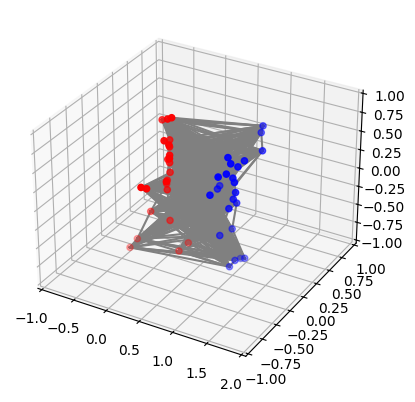

In [43]:
# Visualizing final joint skeletons
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(projection="3d")
ax.set_xlim([-1, 2])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])

# Auxiliar joint poses that will be removed once we have the non-normalized pipeline
joint_poses_aux = joint_poses[42].copy()
joint_poses_aux[24:, 2] = joint_poses_aux[24:, 2] + 1

ax.scatter(joint_poses_aux[:24, 2], joint_poses_aux[:24, 0], -joint_poses_aux[:24, 1], color='red')
ax.scatter(joint_poses_aux[24:, 2], joint_poses_aux[24:, 0], -joint_poses_aux[24:, 1], color='blue')

for (start, end) in adj_matrix:
    xs = [joint_poses_aux[start, 2], joint_poses_aux[end, 2]]
    ys = [joint_poses_aux[start, 0], joint_poses_aux[end, 0]]
    zs = [-joint_poses_aux[start, 1], -joint_poses_aux[end, 1]]
    ax.plot(xs, ys, zs, color='grey')

plt.tight_layout()
plt.show()

In [49]:
# Building sequences
import torch

joint_poses = torch.Tensor(joint_poses)

seq_len = 64
num_seqs = joint_poses.shape[0] // seq_len
batches = torch.stack([joint_poses[i*seq_len:(i+1)*seq_len] for i in range(num_seqs)])

print('Shape of data with sequences: {}'.format(batches.shape))

Shape of data with sequences: torch.Size([4, 64, 48, 3])


# Bulding models

In [8]:
# Defining the model
import torch.nn as nn
from torch.nn import Linear
from torch_geometric.nn.models import MLP

class nri_mlp_encoder(nn.Module):
    def __init__(self, n_in, n_hid, n_out, do_prob=0., factor=True):
        super(nri_mlp_encoder, self).__init__()

        self.mlp1 = MLP([n_in, n_hid, n_hid], dropout=do_prob, act='relu', norm='batch_norm')
        self.mlp2 = MLP([n_hid * 2, n_hid, n_hid], dropout=do_prob, act='relu', norm='batch_norm')
        self.mlp3 = MLP([n_hid, n_hid, n_hid], dropout=do_prob, act='relu', norm='batch_norm')

        self.factor = factor
        if self.factor:
            self.mlp4 = MLP([n_hid * 3, n_hid, n_hid], dropout=do_prob)
        
        else:
            self.mlp4 = MLP([n_hid * 2, n_hid, n_hid], dropout=do_prob)
            
        self.fc_out = Linear(n_hid, n_out)
        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, Linear):
                nn.init.xavier_normal_(m.weight.data)
                m.bias.data.fill_(0.1)

    def edge2node(self, x, rel_rec, rel_send):
        incoming = torch.matmul(rel_rec.t(), x)
        
        return incoming / incoming.size(1)

    def node2edge(self, x, rel_rec, rel_send):
        receivers = torch.matmul(rel_rec, x)
        senders = torch.matmul(rel_send, x)
        
        edges = torch.cat([senders, receivers], dim=2)
        
        return edges

    def forward(self, inputs, rel_rec, rel_send):
        # [num_seqs, num_timesteps, num_atoms, num_dims] -> [num_seqs, num_atoms, num_timesteps*num_dims]
        x = inputs.view(inputs.size(0), inputs.size(2), -1)

        x = self.mlp1(x)
        x = self.node2edge(x, rel_rec, rel_send)
        x = self.mlp2(x)
        x_skip = x.copy()

        if self.factor:
            x = self.edge2node(x, rel_rec, rel_send)
            x = self.mlp3(x)
            x = self.node2edge(x, rel_rec, rel_send)
            x = torch.cat((x, x_skip), dim=2)
            x = self.mlp4(x)
        else:
            x = self.mlp3(x)
            x = torch.cat((x, x_skip), dim=2)
            x = self.mlp4(x)

        return self.fc_out(x)

In [ ]:
# # Training process: hyperparameters selection, model instantiation and training loop
# from tqdm import tqdm
# import math

# # Choosing hyperparameters to be the same as in the provided paper
# in_dim = n_joints * 3
# hid_dim = 384
# lat_dim = 256
# seq_len = 128
# num_layers = 3
# epochs = 150

# # Instantiating model, moving it to device and initializing optimizer
# model = VAE(in_dim, hid_dim, lat_dim, seq_len, num_layers)
# model.to(device)
# model.apply(weight_initialization)

# optimizer = torch.optim.Adam(model.parameters())

# # Training loop
# best_loss = np.inf
# best_model_path = 'data/best_training_model.pth'
# early_stop_max = math.ceil(0.01*epochs)
# early_stop_counter = 0
# train_loss_series = []
# val_loss_series = []
# for epoch in tqdm(range(epochs)):
#     model.train()
#     train_loss = 0
    
#     for batch_id, (dance_seq,) in enumerate(train_loader):
#         optimizer.zero_grad()
        
#         seq_prime, mean, logvar = model(dance_seq)
        
#         loss = loss_function(seq_prime, dance_seq, mean, logvar)
#         loss.backward()
#         train_loss += loss.item()
        
#         optimizer.step()

#     avg_train_loss = train_loss/len(dancer_data)
#     train_loss_series.append(avg_train_loss)
#     print('Epoch: {}, Average training Loss: {}'.format(epoch, avg_train_loss))

#     if epoch%5 == 0:
#         model.eval()
#         val_loss = 0

#         with torch.no_grad():
#             for (dance_seq,) in val_loader:
#                 seq_prime, mean, logvar = model(dance_seq)
#                 loss = loss_function(seq_prime, dance_seq, mean, logvar)
#                 val_loss += loss.item()

#         avg_val_loss = val_loss/len(val_loader)
#         val_loss_series.append(avg_val_loss)
#         print('Epoch: {}, Average validation Loss: {}'.format(epoch, avg_val_loss))

#         if avg_val_loss < best_loss:
#             best_loss = avg_val_loss
#             early_stop_counter = 0
            
#             torch.save(model.state_dict(), best_model_path)
#             print('Saved new best model with validation loss: {}'.format(best_loss))
            
#         else:
#             early_stop_counter += 1

#     if early_stop_counter > early_stop_max:
#         break